# Quantum dataset - logistic

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "quantum-gamma-limit"

nb_devices_for_the_run = 20

# Data preparation

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/quantum/phy_train.csv', sep="\t", header = None)
columns_with_missing_values = []
for col in range(1, len(data.columns)):
    if (not data[data[col] == 999].empty) or (not data[data[col] == 9999].empty):
        columns_with_missing_values.append(col)
print("Following columns has missing values :", columns_with_missing_values)
data.drop(data.columns[columns_with_missing_values],axis=1,inplace=True)
print("This columns has been removed.")
data = data.rename(columns={ 0: "ID", 1: "state", 80: "nothing" })
data = data.drop(['ID', 'nothing'], axis=1)
data.head()

Following columns has missing values : [21, 22, 23, 30, 45, 46, 47, 56]
This columns has been removed.


,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,0,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [3]:
dim_notebook = len(data.columns) - 1 # We don't count as dimension the labels
print("There is " + str(dim_notebook) + " dimensions.")

There is 70 dimensions.


In [4]:
# Showing that there is empty columns (with null std).
small_std = []
std_data = data.std()
for i in range(len(data.columns)):
    if std_data.iloc[i] < 1e-5:
        small_std.append(i)
print(small_std)
data.iloc[:,small_std].describe()

[40, 41, 42, 43, 44]


,48,49,50,51,52
count,50000.0,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [5]:
# Removing columns with null std
data = data.loc[:, (data.std() > 1e-6)]
dim_notebook = len(data.columns) - 1
print("Now, there is " + str(dim_notebook) + " dimensions.")

Now, there is 65 dimensions.


In [6]:
data = data.replace({'state': {0: -1}})
data.head()

,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,-1,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,-1,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [7]:
data['state'].value_counts()

-1    25139
 1    24861
Name: state, dtype: int64

## Handling IID data

In [8]:
def quantum_step_size(it, L, omega, N): return 1 / (8 * L)

In [9]:
#Separing features and labels
X_data = data.loc[:, data.columns != "state"]
Y_data = data.loc[:, data.columns == "state"]

#Data normalisation
X_scaled = scale(X_data)
Y_scaled = Y_data

In [10]:
#Transforming into torch.FloatTensor
X_merged = torch.tensor(X_scaled, dtype=torch.float64)
Y_merged = torch.tensor(Y_scaled.values, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)

X, Y = [], []
for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")

# Adding a columns of "1" to take into account a potential bias.
X = add_bias_term(X)
dim_notebook = X[0].shape[1]
for x in X:
    print("Number of points on this device:", len(x))

Number of points by devices:  2500
There is 20 devices.
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500


In [11]:
# Checking that data is balanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.4808
ratio of state 1 on this device:  0.5092
ratio of state 1 on this device:  0.5064
ratio of state 1 on this device:  0.4744
ratio of state 1 on this device:  0.494
ratio of state 1 on this device:  0.5192
ratio of state 1 on this device:  0.4844
ratio of state 1 on this device:  0.494
ratio of state 1 on this device:  0.5236
ratio of state 1 on this device:  0.498
ratio of state 1 on this device:  0.4912
ratio of state 1 on this device:  0.4856
ratio of state 1 on this device:  0.4964
ratio of state 1 on this device:  0.5068
ratio of state 1 on this device:  0.5
ratio of state 1 on this device:  0.4924
ratio of state 1 on this device:  0.4936
ratio of state 1 on this device:  0.4928
ratio of state 1 on this device:  0.4916
ratio of state 1 on this device:  0.51


# Handling non-iid data

There is 20 devices.
Number of points on device 0 : 2384
Number of points on device 1 : 2674
Number of points on device 2 : 2505
Number of points on device 3 : 1121
Number of points on device 4 : 2235
Number of points on device 5 : 1823
Number of points on device 6 : 4358
Number of points on device 7 : 1858
Number of points on device 8 : 2479
Number of points on device 9 : 1790
Number of points on device 10 : 1389
Number of points on device 11 : 2004
Number of points on device 12 : 1735
Number of points on device 13 : 2215
Number of points on device 14 : 1095
Number of points on device 15 : 10572
Number of points on device 16 : 2486
Number of points on device 17 : 898
Number of points on device 18 : 1382
Number of points on device 19 : 2997
CPU times: user 1h 2min 49s, sys: 9min 55s, total: 1h 12min 45s
Wall time: 32min 53s


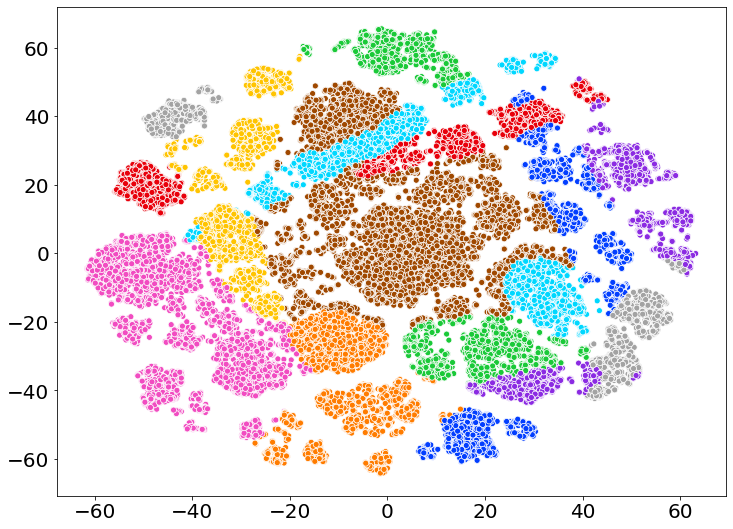

In [12]:
%%time
nb_cluster = nb_devices_for_the_run
embedded_data = pickle_loader("quantum-tsne")
# Finding cluster in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "state", nb_cluster, scale_Y=False)
dim_notebook = X[0].shape[1]

In [13]:
from src.utils.DataClustering import rebalancing_clusters
X_r, Y_r = rebalancing_clusters(X, Y)

Changing : 
(898, 17)
(10572, 15)
Number of points on device 0 : 2384
Number of points on device 1 : 2674
Number of points on device 2 : 2505
Number of points on device 3 : 1121
Number of points on device 4 : 2235
Number of points on device 5 : 1823
Number of points on device 6 : 4358
Number of points on device 7 : 1858
Number of points on device 8 : 2479
Number of points on device 9 : 1790
Number of points on device 10 : 1389
Number of points on device 11 : 2004
Number of points on device 12 : 1735
Number of points on device 13 : 2215
Number of points on device 14 : 1095
Number of points on device 15 : 5286
Number of points on device 16 : 2486
Number of points on device 17 : 6184
Number of points on device 18 : 1382
Number of points on device 19 : 2997


In [14]:
# Checking that data is unbalanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y_r:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.438758389261745
ratio of state 1 on this device:  0.5254300673148841
ratio of state 1 on this device:  0.5141716566866268
ratio of state 1 on this device:  0.7528991971454059
ratio of state 1 on this device:  0.44474272930648767
ratio of state 1 on this device:  0.8332419089413056
ratio of state 1 on this device:  0.31551170261587885
ratio of state 1 on this device:  0.4580193756727664
ratio of state 1 on this device:  0.918918918918919
ratio of state 1 on this device:  0.5636871508379888
ratio of state 1 on this device:  0.23542116630669546
ratio of state 1 on this device:  0.9995009980039921
ratio of state 1 on this device:  0.5919308357348703
ratio of state 1 on this device:  0.4853273137697517
ratio of state 1 on this device:  0.245662100456621
ratio of state 1 on this device:  0.43132803632236094
ratio of state 1 on this device:  0.0148833467417538

In [15]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X_r, Y_r, nb_devices_for_the_run)

In [16]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=50000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
   10000 | 5.3115e-01
   20000 | 5.3115e-01
   30000 | 5.3115e-01
   40000 | 5.3115e-01
Gradient Descent: execution time=4584.799 seconds
Final loss : 0.53115

CPU times: user 3h 50min 31s, sys: 38min 2s, total: 4h 28min 34s
Wall time: 1h 16min 25s


In [17]:
step_formula = [(lambda it, L, omega, N: 20 / (2*L)),
                (lambda it, L, omega, N: 5 / L),
                (lambda it, L, omega, N: 2 / L),
                (lambda it, L, omega, N: 1 / L),
                (lambda it, L, omega, N: 1 / (2*L)),
                (lambda it, L, omega, N: 1 / (4*L)),
                (lambda it, L, omega, N: 1 / (8*L)),
                (lambda it, L, omega, N: 1 / (16*L)),
                (lambda it, L, omega, N: 1 / (32*L)),
                (lambda it, L, omega, N: 1 / (64*L)),
                ]

lable_step_formula = ["N/2L",
                "5/L",
                "2/L",
                "$L^{-1}$",
                "$2L^{-1}$",
                "$4L^{-1}$",
                "$8L^{-1}$",
                "$16L^{-1}$",
                "$32L^{-1}$",
                "$64L^{-1}$",
                ]

## Batch size $= 400$

In [18]:
%%time
batch_size = 400
all_kind_of_compression_res = []
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    losses_by_comp = []
    losses_avg_by_comp = []
    for formula in step_formula:
        multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                                   use_averaging=True, stochastic=True, batch_size=batch_size, 
                                                   step_formula=formula,
                                                   nb_epoch=250, logs_file="{0}.txt".format(filename))
        losses_by_formula, losses_avg_by_formula = [], []
        for sequence_of_losses, sequence_of_losses_avg in zip(multiple_sg_descent.losses, multiple_sg_descent.averaged_losses):
            losses_by_formula.append(min(sequence_of_losses))
            losses_avg_by_formula.append(min(sequence_of_losses_avg))
        losses_by_comp.append(losses_by_formula)
        losses_avg_by_comp.append(losses_avg_by_formula)
            
    artificial_multiple_descent = MultipleDescentRun()
    artificial_multiple_descent.append_list(losses_by_comp, losses_avg_by_comp)
    all_descent[type_params.name()] = artificial_multiple_descent
    all_kind_of_compression_res.append(all_descent)
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, "{0}-alldescent".format(filename))

100%|██████████| 5/5 [9:56:24<00:00, 7156.84s/it]

CPU times: user 1d 21h 46min 7s, sys: 5h 27min 35s, total: 2d 3h 13min 43s
Wall time: 9h 56min 24s


### Without averaging

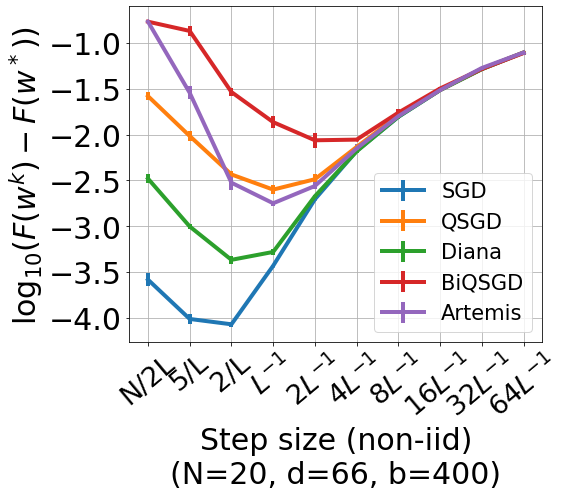

In [19]:
batch_size = 400
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-alldescent".format(filename))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Step size (non-iid)", one_on_two_points=False,
               xlabels=lable_step_formula) 

### With averaging

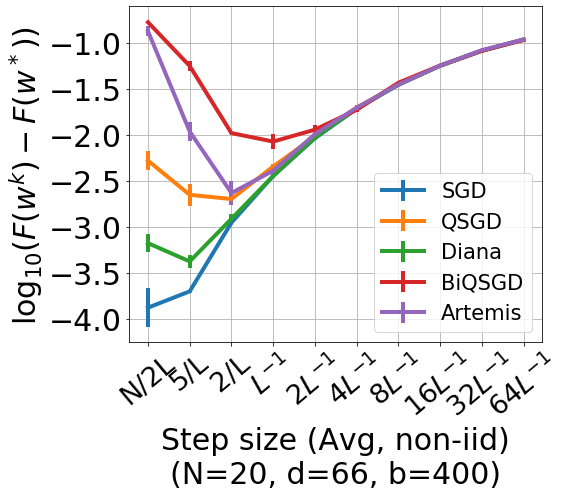

In [20]:
batch_size = 400
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-alldescent".format(filename))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Step size (Avg, non-iid)", one_on_two_points=False,
               xlabels=lable_step_formula) 
